## Goal
- Implement classification with resnet18 in tinyImagenet dataset using d2l library
    - Wrap tiny imagenet data under d2l library
    - Fit with GPU
    - Record validation losses, accuracy, time taken to train

In [ ]:
import torch
import time
import d2l.torch as d2l
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset, Image
import json
import requests

In [2]:
batch_size = 128
num_workers = 2
learning_rate = 0.01
num_epochs = 10
device = d2l.try_gpu()
device

device(type='cuda', index=0)

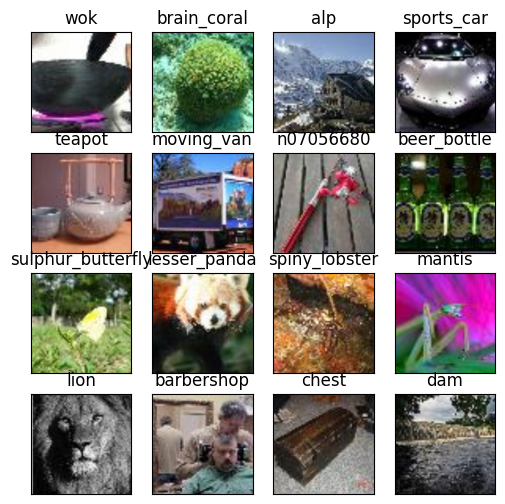

In [6]:
class TinyImagenetD2l(d2l.Module):
    def __init__(self, batch_size, num_workers):
        super().__init__()
        self.save_hyperparameters()
        self.train_data = load_dataset("Maysee/tiny-imagenet", split="train")
        self.val_data = load_dataset("Maysee/tiny-imagenet", split="valid")
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.get_imagenet_labels()

    def get_imagenet_labels(self):
        response = requests.get("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json")
        imagenet_index = json.loads(response.text)
        self.imagenet_reverse_index = { v[0]:v[1] for k, v in imagenet_index.items()}

    def transforms(self, batch):
        batch['image'] = [self.transform(x.convert("RGB")) for x in batch['image']]
        return batch

    def get_dataloader(self, train):
        data = self.train_data if train else self.val_data
        data.set_transform(self.transforms)
        dataloader = DataLoader(data, batch_size=self.batch_size, shuffle=train)
        return dataloader

    def visualize(self, batch, max_images=16):
        images = batch['image'][:max_images].permute(0, 2, 3, 1)
        labels = batch['label'][:max_images].unsqueeze(1)
        labels = self.train_data.features['label'].int2str(labels)
        
        labels = [self.imagenet_reverse_index[label] if label in self.imagenet_reverse_index.keys() else label for label in labels]

        d2l.show_images(images, 4, 4, titles=labels)
        
    

tiny_imagenet = TinyImagenetD2l(batch_size, num_workers)
train_loader = tiny_imagenet.get_dataloader(train=True)
val_loader = tiny_imagenet.get_dataloader(train=False)

tiny_imagenet.visualize(next(iter(train_loader)))

        
